# 데이터 전처리

- 데이터 전처리
    - 태양광 발전량이 0인 시간은 분석에서 제외V
    - 결측치 처리할 것
    - 풍위 수치로 저리V
    <br><br>
- 일조량 분포파악하기
    - 태양광 발전량의 주기성에서 기인한 추세확인
    - 외적 요인이 개입했다는 판단하에 값을 보정
    <br><br>
- 상관관계 재분석
    - 피처엔지니어링에 도움
    <br><br>
- PCA
    - 설명력을 위함
    <br><br>
- 편차를 예측
    - 모든 시간대에 대한 예측을 하는 것에 무리가 있다면 편차를 예측하는 것도 방법
    - LSTM으로 정해진 셀에 맞는 예측을 하는 것도 좋을 것 같음(추후!)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('merged_pv_data.csv',encoding='cp949',index_col='Unnamed: 0')

In [3]:
df.columns

Index(['날짜', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)', '발전량', 'PM10', 'PM2.5', 'O3', '이산화질소', '일산화질소',
       '아황산가스'],
      dtype='object')

In [4]:
df.drop(['운형(운형약어)','일산화질소','이슬점온도(°C)','증기압(hPa)','지면온도(°C)'],axis=1,inplace=True)

In [5]:
df["날짜"] = pd.to_datetime(df["날짜"])

## 연/월/일/시간

In [6]:
# df["날짜"] = pd.to_datetime(df["날짜"])

# # df_new 데이터프레임에 month와 hour 컬럼 추가
# df['year'] = df['날짜'].dt.year
# df['month'] = df['날짜'].dt.month
# df['hour'] = df['날짜'].dt.hour

# # 결측값 대체를 위해 groupby와 transform을 사용하여 월별, 시간별 평균 계산
# df_filled = df.fillna(df.groupby(['year','month', 'hour']).transform('mean'))

# # 결측값이 있는지 확인
# print(df_filled.isnull().sum())

# 결측값 처리

## 일사/일조량 결측값 채우기

In [7]:
df_new=df

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87447 entries, 0 to 87446
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   날짜             87447 non-null  datetime64[ns]
 1   기온(°C)         87436 non-null  float64       
 2   강수량(mm)        8206 non-null   float64       
 3   풍속(m/s)        87423 non-null  float64       
 4   풍향(16방위)       86804 non-null  float64       
 5   습도(%)          86969 non-null  float64       
 6   현지기압(hPa)      87398 non-null  float64       
 7   해면기압(hPa)      87446 non-null  float64       
 8   일조(hr)         47636 non-null  float64       
 9   일사(MJ/m2)      47853 non-null  float64       
 10  전운량(10분위)      76500 non-null  float64       
 11  중하층운량(10분위)    80497 non-null  float64       
 12  최저운고(100m )    48812 non-null  float64       
 13  시정(10m)        83162 non-null  float64       
 14  5cm 지중온도(°C)   87281 non-null  float64       
 15  10cm 지중온도(°C)  8735

In [9]:
df.isnull().sum()

날짜                   0
기온(°C)              11
강수량(mm)          79241
풍속(m/s)             24
풍향(16방위)           643
습도(%)              478
현지기압(hPa)           49
해면기압(hPa)            1
일조(hr)           39811
일사(MJ/m2)        39594
전운량(10분위)        10947
중하층운량(10분위)       6950
최저운고(100m )      38635
시정(10m)           4285
5cm 지중온도(°C)       166
10cm 지중온도(°C)       89
20cm 지중온도(°C)       26
30cm 지중온도(°C)       73
발전량                 18
PM10             11015
PM2.5            14993
O3                3451
이산화질소             3531
아황산가스             4256
dtype: int64

In [10]:
# 일사량은 확인 결과 NAN인 값은 전부 0으로 판명
df_new['일사(MJ/m2)'].fillna(0.0, inplace=True)

In [11]:
# 일사량이 0이면 일조량도 0.
cond = (df_new['일조(hr)'].isna()) & (df_new['일사(MJ/m2)'] == 0)
df_new.loc[cond, '일조(hr)'] = 0

In [12]:
df_new.isnull().sum()

날짜                   0
기온(°C)              11
강수량(mm)          79241
풍속(m/s)             24
풍향(16방위)           643
습도(%)              478
현지기압(hPa)           49
해면기압(hPa)            1
일조(hr)             222
일사(MJ/m2)            0
전운량(10분위)        10947
중하층운량(10분위)       6950
최저운고(100m )      38635
시정(10m)           4285
5cm 지중온도(°C)       166
10cm 지중온도(°C)       89
20cm 지중온도(°C)       26
30cm 지중온도(°C)       73
발전량                 18
PM10             11015
PM2.5            14993
O3                3451
이산화질소             3531
아황산가스             4256
dtype: int64

## csv 파일 보면서 판단

In [13]:
df_find = df_new[np.isnan(df_new['전운량(10분위)'])]

In [14]:
df_find.to_csv('전운량결측.csv',encoding='cp949')

In [15]:
# df_no_nan = df_new.dropna(subset=['전운량(10분위)'])

.

## 보간법으로 결측값 처리

In [16]:
# 결측값을 보간하기 위해 시간을 색인으로 설정
#df_new['날짜'] = pd.to_datetime(df_new['날짜'])
#df_new = df_new.set_index('날짜')

# interpolate() 함수를 사용하여 결측값 보간
df_new['풍향(16방위)'] = df_new['풍향(16방위)'].interpolate(method='linear')
df_new['기온(°C)'] = df_new['기온(°C)'].interpolate(method='linear')
#df_new['증기압(hPa)'] = df_new['증기압(hPa)'].interpolate(method='linear')
#df_new['이슬점온도(°C)'] = df_new['이슬점온도(°C)'].interpolate(method='linear')
df_new['일조(hr)'] = df_new['일조(hr)'].interpolate(method='linear')
df_new['강수량(mm)'] = df_new['강수량(mm)'].interpolate(method='linear')
#df_new['지면온도(°C)'] = df_new['지면온도(°C)'].interpolate(method='linear')
df_new['전운량(10분위)'] = df_new['전운량(10분위)'].interpolate(method='linear')
df_new['중하층운량(10분위)'] = df_new['중하층운량(10분위)'].interpolate(method='linear')
df_new['최저운고(100m )'] = df_new['최저운고(100m )'].interpolate(method='linear')
df_new['시정(10m)'] = df_new['시정(10m)'].interpolate(method='linear')

# 보간된 데이터 출력
df_new

,날짜,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),...,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),발전량,PM10,PM2.5,O3,이산화질소,아황산가스
0,2013-01-01 01:00:00,-2.2,NaN,3.7,160.0,95.0,1016.4,1021.3,0.0,0.0,...,2.7,3.0,3.7,4.5,0.0,29.0,21.0,0.004,0.022,0.006
1,2013-01-01 02:00:00,-2.4,NaN,3.6,160.0,95.0,1016.3,1021.2,0.0,0.0,...,2.7,3.0,3.7,4.5,0.0,45.0,NaN,0.004,0.012,0.006
2,2013-01-01 03:00:00,-2.7,NaN,3.6,160.0,95.0,1015.9,1020.8,0.0,0.0,...,2.7,3.0,3.7,4.5,0.0,24.0,19.0,0.005,0.012,0.005
3,2013-01-01 04:00:00,-2.9,NaN,4.0,160.0,94.0,1015.1,1020.0,0.0,0.0,...,2.6,3.0,3.7,4.5,0.0,24.0,19.0,0.006,0.009,0.005
4,2013-01-01 05:00:00,-2.4,NaN,3.0,160.0,91.0,1014.4,1019.3,0.0,0.0,...,2.6,3.0,3.7,4.5,0.0,23.0,20.0,0.006,0.005,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87442,2022-12-31 19:00:00,3.2,0.2,2.3,320.0,60.0,1026.1,1031.8,0.0,0.0,...,4.0,4.6,4.8,5.1,0.0,29.0,16.0,0.027,0.016,0.003
87443,2022-12-31 20:00:00,2.8,0.2,1.4,340.0,62.0,1025.7,1031.4,0.0,0.0,...,3.7,4.4,4.9,5.1,0.0,32.0,22.0,0.018,0.022,0.002
87444,2022-12-31 21:00:00,2.2,0.2,0.9,20.0,63.0,1025.2,1030.9,0.0,0.0,...,3.4,4.2,4.8,5.1,0.0,44.0,33.0,0.006,0.032,0.002
87445,2022-12-31 22:00:00,1.7,0.2,1.3,200.0,67.0,1025.5,1031.2,0.0,0.0,...,3.1,4.1,4.7,5.1,0.0,46.0,37.0,0.005,0.030,0.002


In [17]:
df_new.isnull().sum()

날짜                   0
기온(°C)               0
강수량(mm)              5
풍속(m/s)             24
풍향(16방위)             0
습도(%)              478
현지기압(hPa)           49
해면기압(hPa)            1
일조(hr)               0
일사(MJ/m2)            0
전운량(10분위)            2
중하층운량(10분위)          2
최저운고(100m )          2
시정(10m)              2
5cm 지중온도(°C)       166
10cm 지중온도(°C)       89
20cm 지중온도(°C)       26
30cm 지중온도(°C)       73
발전량                 18
PM10             11015
PM2.5            14993
O3                3451
이산화질소             3531
아황산가스             4256
dtype: int64

In [18]:
df_new.columns

Index(['날짜', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '현지기압(hPa)',
       '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)',
       '최저운고(100m )', '시정(10m)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)', '발전량', 'PM10', 'PM2.5', 'O3', '이산화질소',
       '아황산가스'],
      dtype='object')

## 지수가중이동평균

In [19]:
# cols = [col for col in df_new.columns if col not in ['날짜', '기온(°C)', '강수량(mm)', '풍향(16방위)',
#                                                      '증기압(hPa)','이슬점온도(°C)', '해면기압(hPa)', '일조(hr)',
#                                                      '일사(MJ/m2)','전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )',
#                                                      '시정(10m)', '지면온도(°C)',
#                                                     ]]
N = 12
cols = [col for col in df_new.columns if col not in ['날짜', '기온(°C)', '강수량(mm)', '풍향(16방위)',
                                                     '증기압(hPa)','해면기압(hPa)', '일조(hr)',
                                                     '일사(MJ/m2)','전운량(10분위)', '최저운고(100m )',
                                                     '시정(10m)', '지면온도(°C)',
                                                    ]]
for col in cols:
    tmp2 = df_new[col].ewm(alpha=2/(N+1), adjust=True, min_periods=1).mean()
    idx = df_new[df_new[col].isna()].index
    
    for k in idx:
        df_new.loc[k, col] = tmp2.loc[k]
        tmp2.loc[k] = df_new.loc[k, col]  # 채워진 값을 tmp2에 반영

In [20]:
df_new.isnull().sum()

날짜               0
기온(°C)           0
강수량(mm)          5
풍속(m/s)          0
풍향(16방위)         0
습도(%)            0
현지기압(hPa)        0
해면기압(hPa)        1
일조(hr)           0
일사(MJ/m2)        0
전운량(10분위)        2
중하층운량(10분위)      2
최저운고(100m )      2
시정(10m)          2
5cm 지중온도(°C)     0
10cm 지중온도(°C)    0
20cm 지중온도(°C)    0
30cm 지중온도(°C)    0
발전량              0
PM10             0
PM2.5            0
O3               0
이산화질소            0
아황산가스            0
dtype: int64

# EDA & Feature engineering

## 데이터 범위 제한
- 태양광 발전이 가능한 시간(6h~20h)만으로 제한

In [21]:
df["날짜"] = pd.to_datetime(df["날짜"])

# 6:00 ~ 20:00 범위의 데이터만 추출하여 새로운 데이터프레임 생성
df_new = df.loc[(df["날짜"].dt.hour >= 6) & (df["날짜"].dt.hour <= 20)]

In [22]:
# 결과 확인
df_new.isnull().sum()

날짜               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
풍향(16방위)         0
습도(%)            0
현지기압(hPa)        0
해면기압(hPa)        0
일조(hr)           0
일사(MJ/m2)        0
전운량(10분위)        0
중하층운량(10분위)      0
최저운고(100m )      0
시정(10m)          0
5cm 지중온도(°C)     0
10cm 지중온도(°C)    0
20cm 지중온도(°C)    0
30cm 지중온도(°C)    0
발전량              0
PM10             0
PM2.5            0
O3               0
이산화질소            0
아황산가스            0
dtype: int64

In [23]:
df_new=df_new.reset_index()

In [24]:
df_new.drop('index',axis=1,inplace=True)

In [25]:
df_new.to_csv('지수가중이동평균_지면온도제외.csv',encoding='cp949')

## 데이터 타입 변환
- 풍향을 16방위 기준으로 범주형으로 

In [26]:
df_new['풍향(16방위)']=df_new['풍향(16방위)']/22.5
df_new['풍향(16방위)']=round(df_new['풍향(16방위)'],0)

In [27]:
df_new['풍향(16방위)'] = df_new['풍향(16방위)'].astype('str')

In [28]:
df_new.loc[df_new['풍향(16방위)'] == '15.0', '풍향(16방위)'] = '북북서'
df_new.loc[df_new['풍향(16방위)'] == '14.0', '풍향(16방위)'] = '북서'
df_new.loc[df_new['풍향(16방위)'] == '13.0', '풍향(16방위)'] = '서북서'
df_new.loc[df_new['풍향(16방위)'] == '12.0', '풍향(16방위)'] = '서'
df_new.loc[df_new['풍향(16방위)'] == '11.0', '풍향(16방위)'] = '서남서'
df_new.loc[df_new['풍향(16방위)'] == '10.0', '풍향(16방위)'] = '남서'
df_new.loc[df_new['풍향(16방위)'] == '9.0', '풍향(16방위)'] = '남남서'
df_new.loc[df_new['풍향(16방위)'] == '8.0', '풍향(16방위)'] = '남'
df_new.loc[df_new['풍향(16방위)'] == '7.0', '풍향(16방위)'] = '남남동'
df_new.loc[df_new['풍향(16방위)'] == '6.0', '풍향(16방위)'] = '남동'
df_new.loc[df_new['풍향(16방위)'] == '5.0', '풍향(16방위)'] = '동남동'
df_new.loc[df_new['풍향(16방위)'] == '4.0', '풍향(16방위)'] = '동'
df_new.loc[df_new['풍향(16방위)'] == '3.0', '풍향(16방위)'] = '동북동'
df_new.loc[df_new['풍향(16방위)'] == '2.0', '풍향(16방위)'] = '북동'
df_new.loc[df_new['풍향(16방위)'] == '1.0', '풍향(16방위)'] = '북북동'
df_new.loc[df_new['풍향(16방위)'] == '0.0', '풍향(16방위)'] = '북'

## 범주형 데이터 인코딩
- 범주형으로 나눈 데이터를 원-핫 인코딩

In [29]:
wind_direction_dummies = pd.get_dummies(df_new['풍향(16방위)'], prefix='풍향(16방위)')
df_new = pd.concat([df_new, wind_direction_dummies], axis=1)

In [30]:
df_new.drop(['풍향(16방위)_16.0','풍향(16방위)'],axis=1,inplace=True)

In [31]:
# ### 이런 방식은 약간 위험하긴함 ###


# # df_new 데이터프레임에 month와 hour 컬럼 추가
# df_new['year'] = df_new['날짜'].dt.year
# df_new['month'] = df_new['날짜'].dt.month
# df_new['hour'] = df_new['날짜'].dt.hour

# # 결측값 대체를 위해 groupby와 transform을 사용하여 월별, 시간별 평균 계산
# df_filled = df_new.fillna(df_new.groupby(['year','month', 'hour']).transform('mean'))

# # 결측값이 있는지 확인
# print(df_filled.isnull().sum())

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

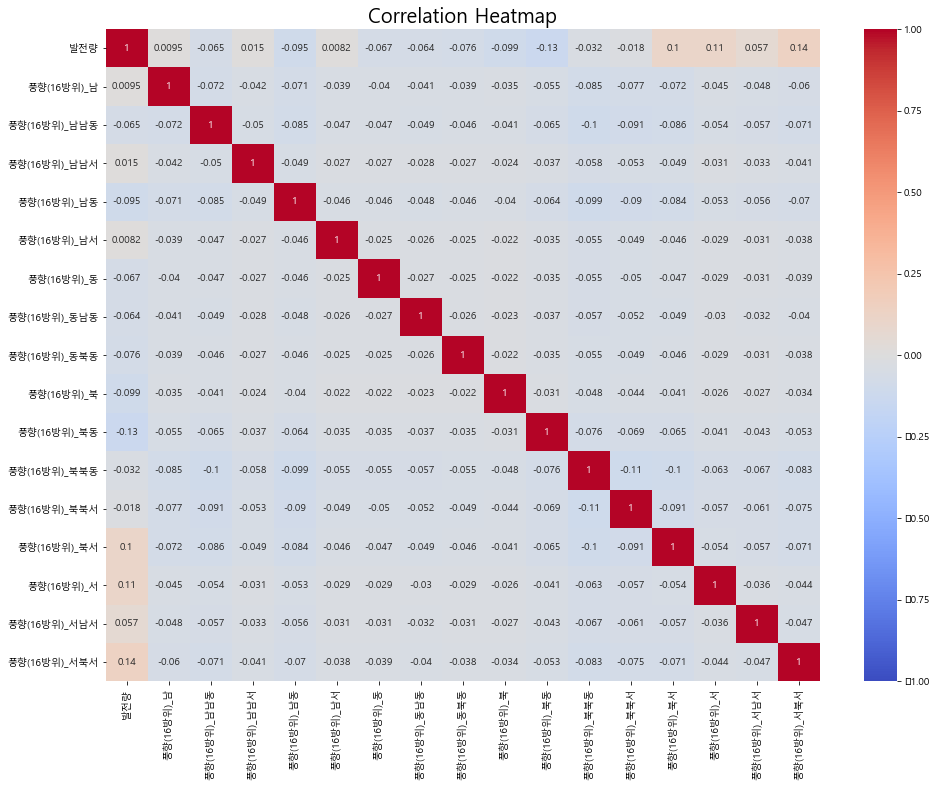

In [32]:
plt.rc('font', family='Malgun Gothic')

selected_features = ['발전량', '풍향(16방위)_남', '풍향(16방위)_남남동',
       '풍향(16방위)_남남서', '풍향(16방위)_남동', '풍향(16방위)_남서', '풍향(16방위)_동',
       '풍향(16방위)_동남동', '풍향(16방위)_동북동', '풍향(16방위)_북', '풍향(16방위)_북동',
       '풍향(16방위)_북북동', '풍향(16방위)_북북서', '풍향(16방위)_북서', '풍향(16방위)_서',
       '풍향(16방위)_서남서', '풍향(16방위)_서북서']
df_new_selected = df_new[selected_features]


corr = df_new_selected.corr()
plt.figure(figsize=(16, 12))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

In [33]:
df_new.columns

Index(['날짜', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '현지기압(hPa)', '해면기압(hPa)',
       '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )',
       '시정(10m)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)', '발전량', 'PM10', 'PM2.5', 'O3', '이산화질소', '아황산가스',
       '풍향(16방위)_남', '풍향(16방위)_남남동', '풍향(16방위)_남남서', '풍향(16방위)_남동',
       '풍향(16방위)_남서', '풍향(16방위)_동', '풍향(16방위)_동남동', '풍향(16방위)_동북동',
       '풍향(16방위)_북', '풍향(16방위)_북동', '풍향(16방위)_북북동', '풍향(16방위)_북북서',
       '풍향(16방위)_북서', '풍향(16방위)_서', '풍향(16방위)_서남서', '풍향(16방위)_서북서'],
      dtype='object')

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

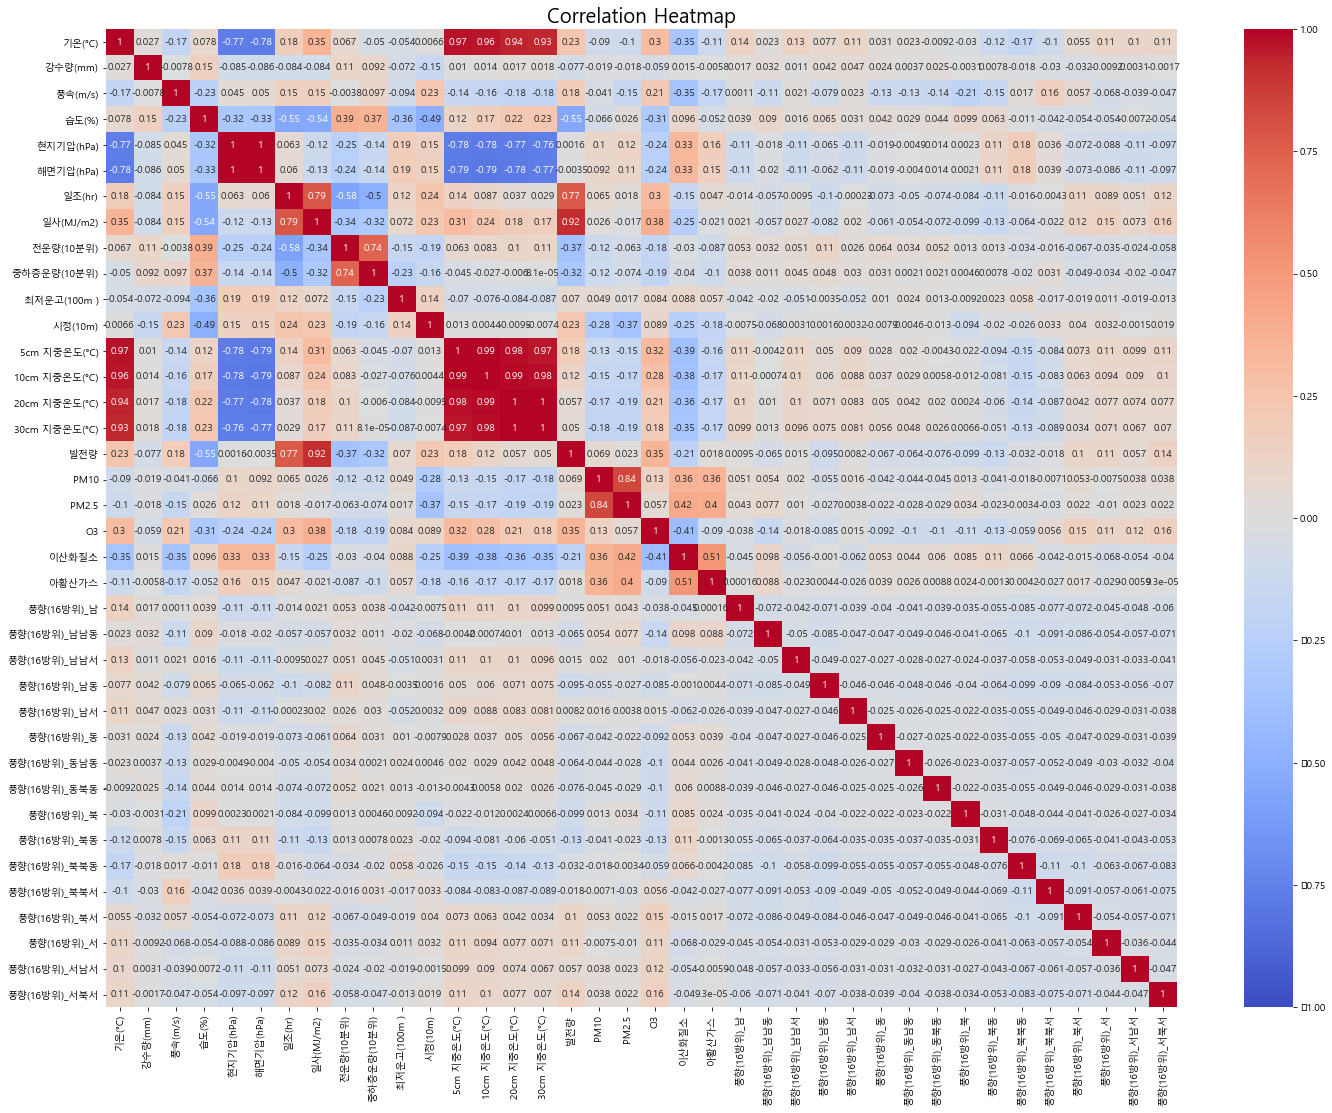

In [35]:
plt.rc('font', family='Malgun Gothic')

selected_features = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', '최저운고(100m )', '시정(10m)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)', '발전량', 'PM10',
       'PM2.5', 'O3', '이산화질소', '아황산가스', '풍향(16방위)_남', '풍향(16방위)_남남동',
       '풍향(16방위)_남남서', '풍향(16방위)_남동', '풍향(16방위)_남서', '풍향(16방위)_동',
       '풍향(16방위)_동남동', '풍향(16방위)_동북동', '풍향(16방위)_북', '풍향(16방위)_북동',
       '풍향(16방위)_북북동', '풍향(16방위)_북북서', '풍향(16방위)_북서', '풍향(16방위)_서',
       '풍향(16방위)_서남서', '풍향(16방위)_서북서']
df_new_selected = df_new[selected_features]


corr = df_new_selected.corr()
plt.figure(figsize=(24, 18))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

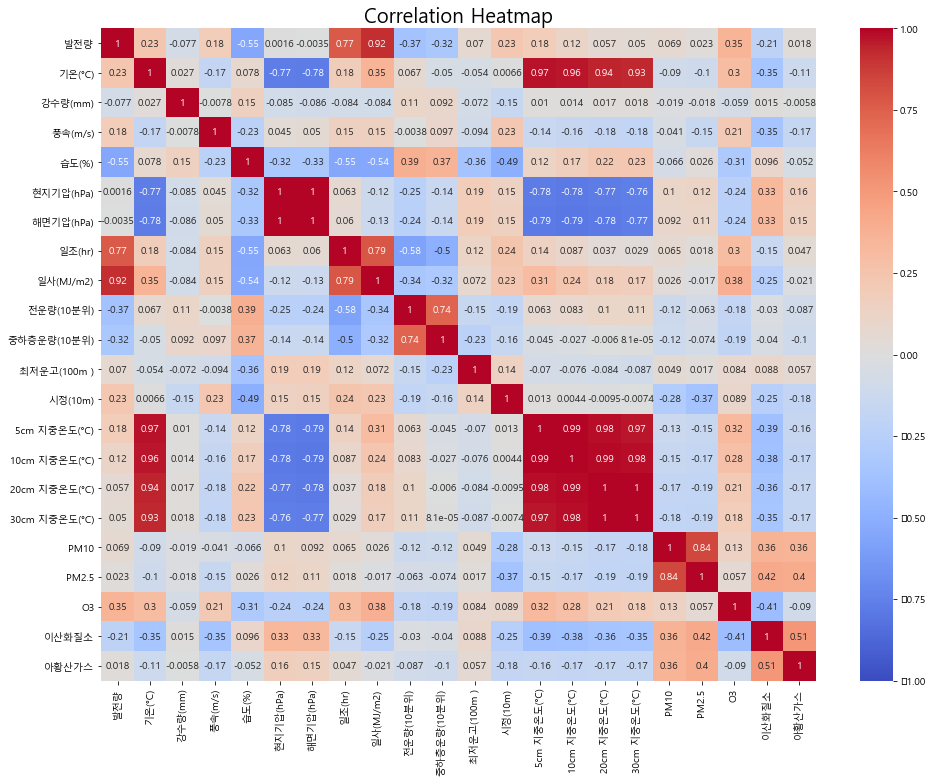

In [37]:
plt.rc('font', family='Malgun Gothic')

selected_features = ['발전량', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)',
       '전운량(10분위)', '중하층운량(10분위)',  '최저운고(100m )', '시정(10m)',
        '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)', 'PM10', 'PM2.5', 'O3', '이산화질소', 
       '아황산가스']
df_new_selected = df_new[selected_features]

corr = df_new_selected.corr()
plt.figure(figsize=(16, 12))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

- 5cm 지중온도, 10cm 지중온도, 20cm 지중온도, 30cm 지중온도는 발전량과 딱히 상관관계도 없고 기온과 상관관계가 매우 커서 다중공선성 문제가 우려되므로 DROP 결정.

In [38]:
df_new.drop(['5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)'],axis=1,inplace=True)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

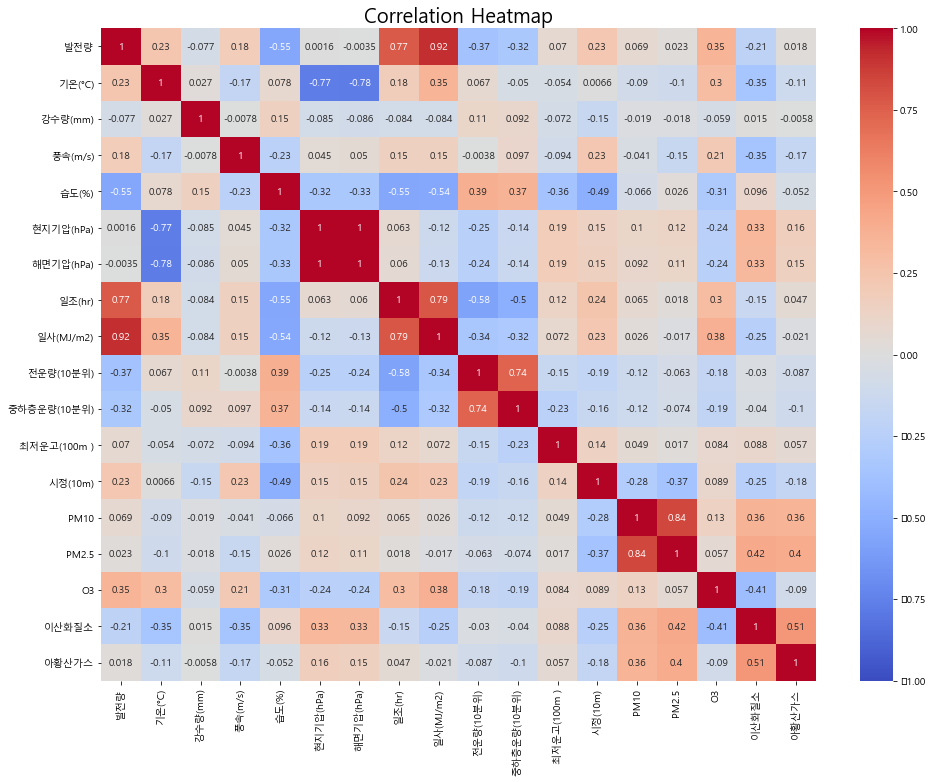

In [41]:
plt.rc('font', family='Malgun Gothic')

selected_features = ['발전량', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', 
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)',
       '전운량(10분위)', '중하층운량(10분위)',  '최저운고(100m )', '시정(10m)',
        'PM10', 'PM2.5', 'O3', '이산화질소',
       '아황산가스']
df_new_selected = df_new[selected_features]

corr = df_new_selected.corr()
plt.figure(figsize=(16, 12))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

- 해면기압과 현지기압은 상관관계가 1이 나오므로 하나를 DROP 해야하는데 ASOS 데이터가 정확한 관측지점의 정보가 아니므로 현지기압을 DROP.

In [42]:
df_new.drop(['현지기압(hPa)'],axis=1,inplace=True)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

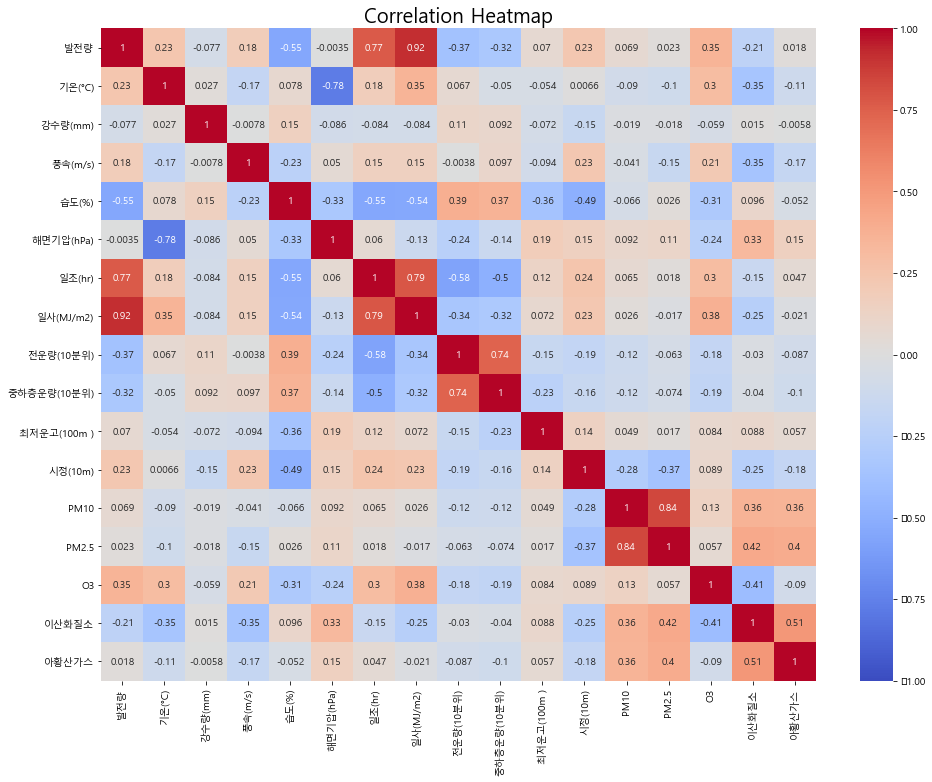

In [43]:
plt.rc('font', family='Malgun Gothic')

selected_features = ['발전량', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)',
       '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )', '시정(10m)',
         'PM10', 'PM2.5', 'O3', '이산화질소', 
       '아황산가스']
df_new_selected = df_new[selected_features]

corr = df_new_selected.corr()
plt.figure(figsize=(16, 12))
plt.title('Correlation Heatmap', fontsize=20)
sns.heatmap(corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

In [44]:
corr = df_new.drop('발전량', axis=1).corrwith(df_new['발전량'])
corr = corr.sort_values(ascending=False)
corr

일사(MJ/m2)       0.920928
일조(hr)          0.772040
O3              0.351932
기온(°C)          0.234711
시정(10m)         0.232359
풍속(m/s)         0.184458
풍향(16방위)_서북서    0.139665
풍향(16방위)_서      0.108943
풍향(16방위)_북서     0.101969
최저운고(100m )     0.070118
PM10            0.069047
풍향(16방위)_서남서    0.056507
PM2.5           0.022754
아황산가스           0.017801
풍향(16방위)_남남서    0.014829
풍향(16방위)_남      0.009515
풍향(16방위)_남서     0.008236
해면기압(hPa)      -0.003524
풍향(16방위)_북북서   -0.017885
풍향(16방위)_북북동   -0.032461
풍향(16방위)_동남동   -0.063753
풍향(16방위)_남남동   -0.064511
풍향(16방위)_동     -0.067432
풍향(16방위)_동북동   -0.076102
강수량(mm)        -0.076756
풍향(16방위)_남동    -0.094817
풍향(16방위)_북     -0.098875
풍향(16방위)_북동    -0.128562
이산화질소          -0.214843
중하층운량(10분위)    -0.322157
전운량(10분위)      -0.372331
습도(%)          -0.551062
dtype: float64

In [45]:
df_new.describe()

,기온(°C),강수량(mm),풍속(m/s),습도(%),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m ),...,풍향(16방위)_동남동,풍향(16방위)_동북동,풍향(16방위)_북,풍향(16방위)_북동,풍향(16방위)_북북동,풍향(16방위)_북북서,풍향(16방위)_북서,풍향(16방위)_서,풍향(16방위)_서남서,풍향(16방위)_서북서
count,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,...,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000,54661.000000
mean,15.245943,0.477057,3.672401,73.506964,1016.590463,0.422037,0.908662,5.501209,3.540919,16.071498,...,0.026783,0.024460,0.019301,0.046413,0.106346,0.088363,0.078905,0.032692,0.036589,0.055158
std,9.500602,1.498659,2.279549,17.242254,8.220343,0.445676,0.931292,3.696339,3.437479,13.808179,...,0.161451,0.154473,0.137581,0.210381,0.308283,0.283824,0.269592,0.177832,0.187753,0.228291
min,-12.800000,0.000000,0.000000,13.000000,983.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.100000,0.000000,2.000000,61.000000,1010.000000,0.000000,0.060000,2.000000,0.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16.000000,0.073333,3.200000,74.000000,1016.700000,0.200000,0.590000,6.000000,3.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23.400000,0.300000,4.900000,88.000000,1023.100000,1.000000,1.570000,9.000000,7.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36.500000,42.400000,17.700000,100.000000,1038.800000,1.000000,3.720000,10.000000,10.000000,76.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 일사, 일조와 발전량의 관계 파악

In [ ]:
df_new['일사(MJ/m2)']

In [ ]:
df_year = df_new.copy()
df_year['날짜'] = pd.to_datetime(df_new['날짜'])
df_year['연도'] = df_new['날짜'].dt.year
df_year['월'] = df_new['날짜'].dt.month
df_year = df_year.drop('날짜', axis=1)

In [ ]:
df_year

In [ ]:
df_year_monthly = df_year.groupby(['연도', '월'])['일사(MJ/m2)'].mean().reset_index()

In [ ]:
sns.lineplot(x='월', y='일사(MJ/m2)', hue='연도', data=df_year_monthly,palette='bright')

In [ ]:
yearly_sum = df_year.groupby('연도').sum()

In [ ]:
yearly_mean = df_year.groupby('연도').mean()

In [ ]:
yearly_sum

In [ ]:
yearly=df_year.groupby('연도')

In [ ]:
import matplotlib.pyplot as plt

# 막대그래프로 시각화
yearly_mean['기온(°C)'].plot(kind='bar')
plt.title('연도별 기온 평균 추이')
plt.xlabel('연도')
plt.ylabel('기온(°C)')
plt.show()

In [ ]:
# 막대그래프로 시각화
yearly_sum['일사(MJ/m2)'].plot(kind='bar')
plt.title('연도별 일사량 추이')
plt.xlabel('연도')
plt.ylabel('일사량(MJ/m2)')
plt.show()

In [ ]:
# 막대그래프로 시각화
yearly_sum['일조(hr)'].plot(kind='bar')
plt.title('연도별 일조량 추이')
plt.xlabel('연도')
plt.ylabel('일조량(hr)')
plt.show()

In [ ]:
# 막대그래프로 시각화
yearly_sum['발전량'].plot(kind='bar')
plt.title('연도별 발전량 추이')
plt.xlabel('연도')
plt.ylabel('발전량')
plt.show()

In [ ]:
# 막대그래프로 시각화
yearly_sum['지면온도(°C)'].plot(kind='bar',color='green')
plt.title('연도별 지면온도 추이')
plt.xlabel('연도')
plt.ylabel('지면온도(°C)')
plt.show()

# PCA

In [46]:
df_pca = df_new.drop(['풍향(16방위)_남', '풍향(16방위)_남남동',
       '풍향(16방위)_남남서', '풍향(16방위)_남동', '풍향(16방위)_남서', '풍향(16방위)_동',
       '풍향(16방위)_동남동', '풍향(16방위)_동북동', '풍향(16방위)_북', '풍향(16방위)_북동',
       '풍향(16방위)_북북동', '풍향(16방위)_북북서', '풍향(16방위)_북서', '풍향(16방위)_서',
       '풍향(16방위)_서남서', '풍향(16방위)_서북서','날짜'],axis=1)

In [47]:
df_pca

,기온(°C),강수량(mm),풍속(m/s),습도(%),해면기압(hPa),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),발전량,PM10,PM2.5,O3,이산화질소,아황산가스
0,-2.2,0.000000,4.5,95.0,1018.7,0.0,0.00,10.0,6.0,10.000000,1500.0,0.00,26.0,23.000000,0.007,0.006,0.004
1,-1.7,0.000000,5.0,95.0,1018.6,0.0,0.00,10.0,6.0,10.000000,1500.0,0.00,26.0,20.586375,0.006,0.010,0.004
2,-0.4,0.000000,3.2,89.0,1018.9,0.0,0.00,10.0,7.0,9.000000,1500.0,0.00,30.0,24.000000,0.006,0.011,0.004
3,2.6,0.000000,6.0,91.0,1019.6,0.0,0.03,10.0,7.0,8.000000,1300.0,20.16,28.0,23.000000,0.005,0.010,0.004
4,4.2,0.033333,5.8,82.0,1019.9,0.7,0.57,7.0,7.0,9.000000,1300.0,106.80,29.0,27.000000,0.007,0.006,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54656,4.9,0.200000,5.4,51.0,1031.1,1.0,1.15,0.0,0.0,12.777778,4224.0,428.16,28.0,18.000000,0.039,0.009,0.002
54657,4.3,0.200000,5.0,53.0,1031.0,1.0,0.54,0.0,0.0,12.666667,4290.0,53.64,26.0,20.000000,0.035,0.013,0.002
54658,3.7,0.200000,2.8,57.0,1031.1,0.3,0.05,0.0,0.0,12.555556,3775.0,5.76,32.0,19.000000,0.029,0.018,0.002
54659,3.2,0.200000,2.3,60.0,1031.8,0.0,0.00,0.0,0.0,12.444444,3669.0,0.00,29.0,16.000000,0.027,0.016,0.003


In [48]:
df_pca.columns

Index(['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '해면기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )', '시정(10m)',
       '발전량', 'PM10', 'PM2.5', 'O3', '이산화질소', '아황산가스'],
      dtype='object')

## 2차원으로 차원축소

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# 표준화
scaler = StandardScaler()
df_std = scaler.fit_transform(df_pca)

# PCA 모델링
pca = PCA(n_components=2)
pca.fit(df_std)

# 주성분(PC) 산출
pcs = pca.transform(df_std)
pc_df = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
pcs_scaled = min_max_scaler.fit_transform(pc_df)

# 결과 출력
pcs_scaled


array([[-0.49477057, -0.49309561],
       [-0.50478516, -0.47980485],
       [-0.51769587, -0.44785867],
       ...,
       [ 0.09580851, -0.33165328],
       [ 0.01731872, -0.3343042 ],
       [-0.06736736, -0.26960212]])

In [50]:
pcs_scaled = pd.DataFrame(data=pcs_scaled, columns=['PC1', 'PC2'])

In [51]:
pcs_scaled

,PC1,PC2
0,-0.494771,-0.493096
1,-0.504785,-0.479805
2,-0.517696,-0.447859
3,-0.496608,-0.487459
4,-0.219918,-0.444843
...,...,...
54656,0.517761,-0.431192
54657,0.363234,-0.395604
54658,0.095809,-0.331653
54659,0.017319,-0.334304


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


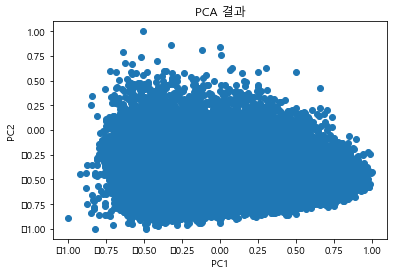

In [52]:
plt.scatter(pcs_scaled['PC1'], pcs_scaled['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA 결과')


plt.show()

In [53]:
from matplotlib import font_manager, rc

# 폰트 경로와 이름을 지정
font_path = 'C:/Windows/Fonts/malgun.ttf' # 나눔글꼴 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 폰트 설정
rc('font', family=font_name)

## 주성분을 이용한 feature importance 시각화


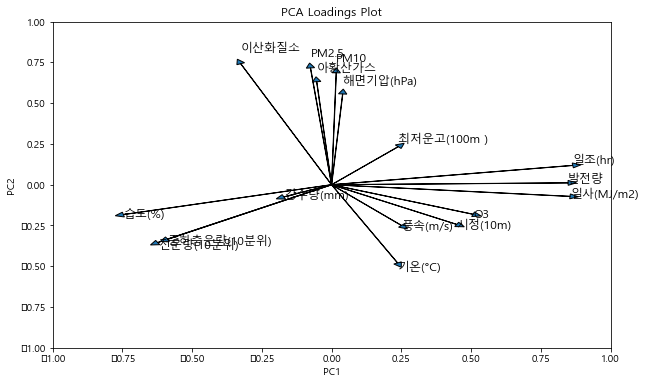

In [54]:
# 주성분을 이용한 feature importance 시각화
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = df_pca.columns.values

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

for i, feature in enumerate(features):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.03, head_length=0.03)
    ax.annotate(feature, (loadings[i, 0], loadings[i, 1]),xytext=(loadings[i, 0], loadings[i, 1] * 1.1), fontsize=12)
    
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA Loadings Plot")

plt.show()

## 다중공선성

In [55]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산을 위해 상수항(intercept) 열 추가
df_pca['intercept'] = 1

# 각 피처의 VIF 계산
vif = pd.DataFrame()
vif['Feature'] = df_pca.columns
vif['VIF'] = [variance_inflation_factor(df_pca.values, i) for i in range(df_pca.shape[1])]

# 결과 출력
print(vif)


        Feature           VIF
0        기온(°C)      3.652163
1       강수량(mm)      1.043849
2       풍속(m/s)      1.555941
3         습도(%)      2.804150
4     해면기압(hPa)      3.598780
5        일조(hr)      3.893200
6     일사(MJ/m2)      9.249688
7     전운량(10분위)      2.775837
8   중하층운량(10분위)      2.431198
9   최저운고(100m )      1.260604
10      시정(10m)      1.690983
11          발전량      7.550570
12         PM10      3.708664
13        PM2.5      3.917592
14           O3      1.633837
15        이산화질소      2.289321
16        아황산가스      1.488965
17    intercept  57292.927284


- PCA와 다중공선성을 통해 알아낸점 : 이슬점온도를 드롭하자

# Clustering

In [56]:
features = ['PC1', 'PC2']
X = pcs_scaled[features]

## Silhouette Score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
X = pcs_scaled[features]

# 클러스터 개수 범위 설정
min_clusters = 2
max_clusters = 10

# 실루엣 계수 계산
silhouette_scores = []
for n_clusters in range(min_clusters, max_clusters + 1):
    # KMeans 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(X)

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 실루엣 계수 그래프 그리기
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


### k=3

In [58]:
from sklearn.cluster import KMeans

In [59]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
pcs_scaled['cluster'] = kmeans.labels_
# 클러스터별로 데이터 분할
cluster0 = pcs_scaled[pcs_scaled['cluster'] == 0]
cluster1 = pcs_scaled[pcs_scaled['cluster'] == 1]
cluster2 = pcs_scaled[pcs_scaled['cluster'] == 2]

In [60]:
pcs_scaled['cluster'].value_counts()

0    22888
1    20504
2    11269
Name: cluster, dtype: int64

In [61]:
cluster0['PC2'].max()

-0.35823718102249813

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


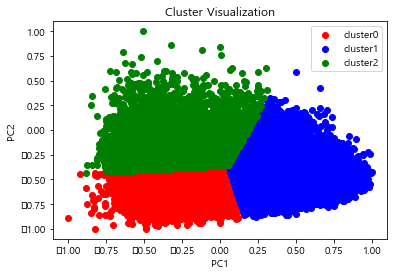

In [62]:
# 클러스터별 데이터 시각화
plt.scatter(cluster0['PC1'], cluster0['PC2'], color='red',label='cluster0')
plt.scatter(cluster1['PC1'], cluster1['PC2'], color='blue',label='cluster1')
plt.scatter(cluster2['PC1'], cluster2['PC2'], color='green',label='cluster2')


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Cluster Visualization')

plt.show()

### k=4

In [63]:
from sklearn.cluster import KMeans

In [64]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [65]:
# 클러스터링 결과 데이터프레임에 추가
pcs_scaled['cluster'] = kmeans.labels_

In [66]:
pcs_scaled['cluster'].value_counts()

3    16604
2    14628
1    14532
0     8897
Name: cluster, dtype: int64

In [67]:
# 클러스터별로 데이터 분할
cluster0 = pcs_scaled[pcs_scaled['cluster'] == 0]
cluster1 = pcs_scaled[pcs_scaled['cluster'] == 1]
cluster2 = pcs_scaled[pcs_scaled['cluster'] == 2]
cluster3 = pcs_scaled[pcs_scaled['cluster'] == 3]

In [68]:
cluster0

,PC1,PC2,cluster
6,-0.116860,-0.223684,0
8,0.108858,0.192771,0
9,-0.092404,0.287432,0
10,-0.241029,0.266285,0
11,-0.449721,0.188227,0
...,...,...,...
54636,0.218726,0.256354,0
54647,-0.303934,-0.320675,0
54648,-0.331817,-0.238985,0
54649,-0.162705,-0.168431,0


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


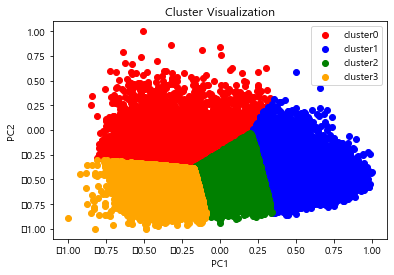

In [69]:
# 클러스터별 데이터 시각화
plt.scatter(cluster0['PC1'], cluster0['PC2'], color='red',label='cluster0')
plt.scatter(cluster1['PC1'], cluster1['PC2'], color='blue',label='cluster1')
plt.scatter(cluster2['PC1'], cluster2['PC2'], color='green',label='cluster2')
plt.scatter(cluster3['PC1'], cluster3['PC2'], color='orange',label='cluster3')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Cluster Visualization')

plt.show()


### k=5

In [70]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

In [71]:
pcs_scaled['cluster'] = kmeans.labels_

In [72]:
pcs_scaled['cluster'].value_counts()

0    14438
3    13305
1    12447
2     8695
4     5776
Name: cluster, dtype: int64

In [73]:
# 클러스터별로 데이터 분할
cluster0 = pcs_scaled[pcs_scaled['cluster'] == 0]
cluster1 = pcs_scaled[pcs_scaled['cluster'] == 1]
cluster2 = pcs_scaled[pcs_scaled['cluster'] == 2]
cluster3 = pcs_scaled[pcs_scaled['cluster'] == 3]
cluster4 = pcs_scaled[pcs_scaled['cluster'] == 4]

In [74]:
cluster0

,PC1,PC2,cluster
0,-0.494771,-0.493096,0
1,-0.504785,-0.479805,0
2,-0.517696,-0.447859,0
3,-0.496608,-0.487459,0
4,-0.219918,-0.444843,0
...,...,...,...
54559,-0.285074,-0.393092,0
54573,-0.385288,-0.414931,0
54575,-0.364903,-0.411140,0
54615,-0.308099,-0.428099,0


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


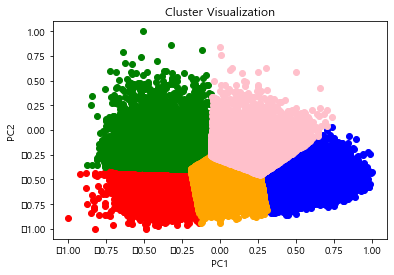

In [75]:
# 클러스터별 데이터 시각화
plt.scatter(cluster0['PC1'], cluster0['PC2'], color='red')
plt.scatter(cluster1['PC1'], cluster1['PC2'], color='blue')
plt.scatter(cluster2['PC1'], cluster2['PC2'], color='green')
plt.scatter(cluster3['PC1'], cluster3['PC2'], color='orange')
plt.scatter(cluster4['PC1'], cluster4['PC2'], color='pink')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster Visualization')

plt.show()

## K값에따른 군집별 평균수치

### k=3

In [76]:
from sklearn.cluster import KMeans
import numpy as np

# 데이터 준비
X = pcs_scaled[features]
K = 3 # 군집 개수

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=K)
cluster_labels = kmeans.fit_predict(X)

# 각 데이터 포인트의 군집 인덱스와 수치를 결합한 배열 생성
data_with_clusters = np.column_stack((cluster_labels, X))

# 군집별 평균 수치 계산
cluster_means = []
for k in range(K):
    cluster_k = data_with_clusters[data_with_clusters[:, 0] == k, 1:]
    cluster_mean = np.mean(cluster_k, axis=0)
    cluster_means.append(cluster_mean)

# 각 군집의 평균 수치 출력
for k, mean in enumerate(cluster_means):
    print("Cluster", k, "Mean:", mean)


Cluster 0 Mean: [ 0.41371363 -0.44628241]
Cluster 1 Mean: [-0.23635512 -0.58031629]
Cluster 2 Mean: [-0.28192586 -0.18741155]


### k=4

In [77]:
from sklearn.cluster import KMeans
import numpy as np

# 데이터 준비
X = pcs_scaled[features]
K = 4 # 군집 개수

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=K)
cluster_labels = kmeans.fit_predict(X)

# 각 데이터 포인트의 군집 인덱스와 수치를 결합한 배열 생성
data_with_clusters = np.column_stack((cluster_labels, X))

# 군집별 평균 수치 계산
cluster_means = []
for k in range(K):
    cluster_k = data_with_clusters[data_with_clusters[:, 0] == k, 1:]
    cluster_mean = np.mean(cluster_k, axis=0)
    cluster_means.append(cluster_mean)

# 각 군집의 평균 수치 출력
for k, mean in enumerate(cluster_means):
    print("Cluster", k, "Mean:", mean)


Cluster 0 Mean: [ 0.06308167 -0.50066841]
Cluster 1 Mean: [-0.34529767 -0.58116774]
Cluster 2 Mean: [ 0.50628086 -0.4313058 ]
Cluster 3 Mean: [-0.293631   -0.15073202]


# NINO3.4

In [78]:
nino=pd.read_csv('nino34.csv',encoding='cp949',index_col='Unnamed: 0')

In [79]:
nino

,연도,1,2,3,4,5,6,7,8,9,10,11,12
0,1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2019,0.51,0.62,0.81,0.67,0.61,0.66,0.41,0.19,0.11,0.55,0.74,0.51
150,2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
151,2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07
152,2022,-0.77,-0.68,-0.84,-0.90,-1.02,-0.77,-0.56,-0.96,-1.06,-0.99,-0.76,-0.86


In [126]:
nino_new = nino.tail(12).copy()

In [127]:
nino_new=nino_new.reset_index()
nino_new.drop(['index'],axis=1,inplace=True)
nino_new

,연도,1,2,3,4,5,6,7,8,9,10,11,12
0,2012,-0.93,-0.61,-0.48,-0.29,-0.18,0.14,0.44,0.66,0.44,0.23,0.33,-0.13
1,2013,-0.42,-0.40,-0.14,-0.08,-0.28,-0.33,-0.28,-0.29,-0.09,-0.24,-0.02,-0.09
2,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
3,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
4,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
5,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85
6,2018,-0.86,-0.73,-0.73,-0.36,-0.12,0.12,0.27,0.05,0.30,0.84,1.00,0.97
7,2019,0.51,0.62,0.81,0.67,0.61,0.66,0.41,0.19,0.11,0.55,0.74,0.51
8,2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
9,2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07


In [128]:
nino_new = nino_new.head(12).copy()
nino_new=nino_new.reset_index()
nino_new.drop(['index'],axis=1,inplace=True)
nino_new

,연도,1,2,3,4,5,6,7,8,9,10,11,12
0,2012,-0.93,-0.61,-0.48,-0.29,-0.18,0.14,0.44,0.66,0.44,0.23,0.33,-0.13
1,2013,-0.42,-0.40,-0.14,-0.08,-0.28,-0.33,-0.28,-0.29,-0.09,-0.24,-0.02,-0.09
2,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
3,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
4,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
5,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85
6,2018,-0.86,-0.73,-0.73,-0.36,-0.12,0.12,0.27,0.05,0.30,0.84,1.00,0.97
7,2019,0.51,0.62,0.81,0.67,0.61,0.66,0.41,0.19,0.11,0.55,0.74,0.51
8,2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
9,2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07


In [132]:
nino_mean=[]
sum=0
for i in range(11):
    nino_sum = round(nino_new['12'][i]+nino_new['1'][i+1]+nino_new['2'][i+1],2)
    nino_mean.append(nino_sum)
    nino_sum = 0
nino_mean

[-0.95, -0.96, 1.93, 7.23, -0.86, -2.44, 2.1, 1.63, -2.96, -2.52, -2.26]

In [133]:
result = []
for num in nino_mean:
    divided = num / 3
    divided = round(divided,2)
    result.append(divided)
result

[-0.32, -0.32, 0.64, 2.41, -0.29, -0.81, 0.7, 0.54, -0.99, -0.84, -0.75]

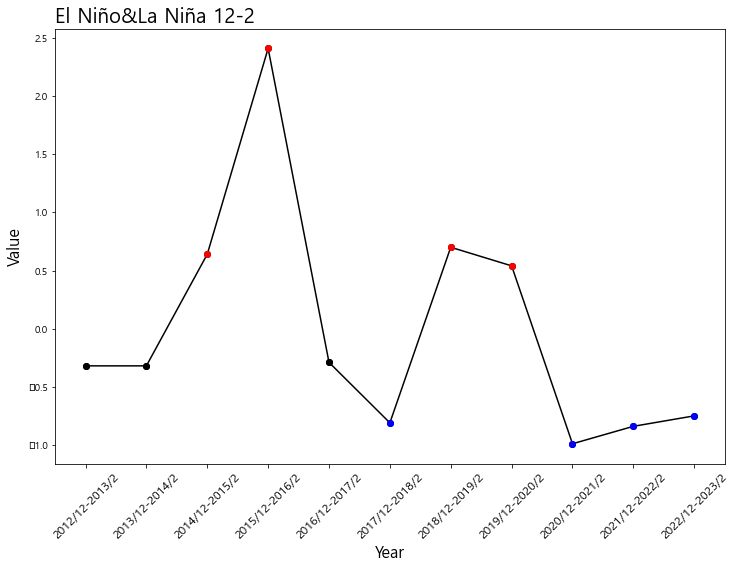

In [163]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

# 데이터
y_data = [-0.32, -0.32, 0.64, 2.41, -0.29, -0.81, 0.7, 0.54, -0.99, -0.84, -0.75]
x_data = range(2012, 2023)

# 그래프 그리기
ax.plot(x_data, y_data, 'o-', color='black')  # 파랑색으로 데이터 포인트와 선 그리기

# 0 이상은 빨강으로, 0 이하는 파랑으로 표시
for x, y in zip(x_data, y_data):
    if y >= 0.5:
        color = 'red'
    elif y <= -0.5:
        color = 'blue'
    else:
        color = 'black'
    ax.plot(x, y, 'o', color=color)

# 그래프 제목과 축 레이블 설정
ax.set_title('El Niño&La Niña 12-2', fontsize=20, loc='left')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Value', fontsize=16)

# x축 눈금 설정
ax.set_xticks(x_data)
ax.set_xticklabels(['2012/12-2013/2', '2013/12-2014/2', '2014/12-2015/2',
                    '2015/12-2016/2', '2016/12-2017/2','2017/12-2018/2',
                    '2018/12-2019/2', '2019/12-2020/2', '2020/12-2021/2',
                    '2021/12-2022/2', '2022/12-2023/2'], rotation=45, fontsize=12)

# 그래프 표시
plt.show()


# PV 12-2

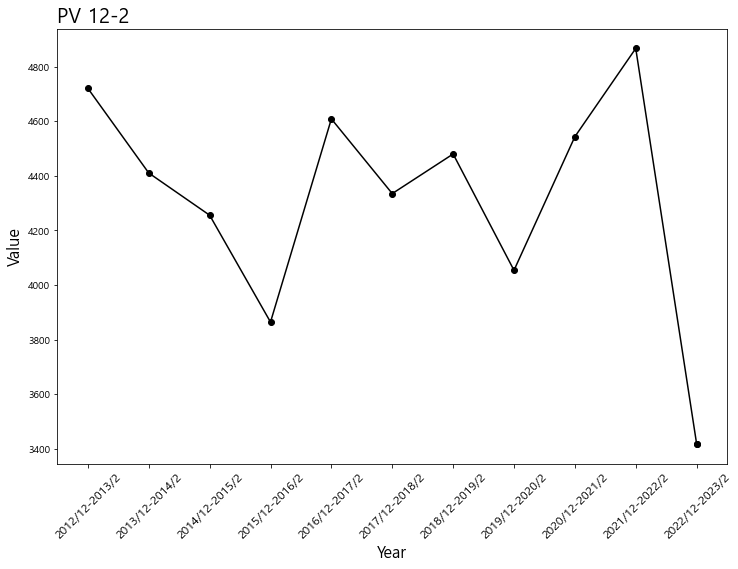

In [162]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

# 데이터
y_data = [4720.166779661016,
 4410.432000000001,
 4256.0,
 3864.9314285714286,
 4608.406666666667,
 4335.06,
 4480.008000000001,
 4054.345494505494,
 4543.310666666667,
 4866.354666666667,
 3419.525161290323]
x_data = range(2012, 2023)

# 그래프 그리기
ax.plot(x_data, y_data, 'o-', color='black')  # 파랑색으로 데이터 포인트와 선 그리기
ax.plot(x, y, 'o', color='black')

# 그래프 제목과 축 레이블 설정
ax.set_title('PV 12-2', fontsize=20, loc='left')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Value', fontsize=16)

# x축 눈금 설정
ax.set_xticks(x_data)
ax.set_xticklabels(['2012/12-2013/2', '2013/12-2014/2', '2014/12-2015/2',
                    '2015/12-2016/2', '2016/12-2017/2','2017/12-2018/2',
                    '2018/12-2019/2', '2019/12-2020/2', '2020/12-2021/2',
                    '2021/12-2022/2', '2022/12-2023/2'], rotation=45, fontsize=12)

# 그래프 표시
plt.show()
